
### GENERATING CAPTIONS FOR IMAGES USING ATTENTION MECHANISM






The objective of this project is to generate accurate captions for the images in the Microsoft COCO dataset. The project uses InceptionV3 to detect objects in the images. The deep learning model uses an encoder and a decoder with GRU and dense layers tuned with an attention module to generate captions. 

## LOADING LIBRARIES


In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import collections
import random
import numpy as np
import os
import time
import json
from PIL import Image

###  MS-COCO dataset

The dataset used for the project is the Microsoft COCO dataset. COCO is a large dataset which is used for a variety of objectives including object detection, object segmentation and image captioning.  The dataset contains over 330,000 images with 5 captions associated with every image. The dataset also has 91 stuff categories, and 1.5 million object instances. 

In [2]:


annotation_folder = '/annotations/'
if not os.path.exists(os.path.abspath('.') + annotation_folder):
  annotation_zip = tf.keras.utils.get_file('captions.zip',
                                           cache_subdir=os.path.abspath('.'),
                                           origin='http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                                           extract=True)
  annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'
  os.remove(annotation_zip)


image_folder = '/train2014/'
if not os.path.exists(os.path.abspath('.') + image_folder):
  image_zip = tf.keras.utils.get_file('train2014.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin='http://images.cocodataset.org/zips/train2014.zip',
                                      extract=True)
  PATH = os.path.dirname(image_zip) + image_folder
  os.remove(image_zip)
else:
  PATH = os.path.abspath('.') + image_folder

13510582272/13510573713 [==============================] - 197s 0us/step


In [3]:
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

captions which have the same image ID are grouped together 
In this project we select 10,000 images and 50,000 samples in total

In [4]:
image_path_to_caption = collections.defaultdict(list)
for val in annotations['annotations']:
  caption = f"</> {val['caption']} </>"
  image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (val['image_id'])
  image_path_to_caption[image_path].append(caption)

In [5]:
image_paths = list(image_path_to_caption.keys())
random.shuffle(image_paths)
train_image_paths = image_paths[:10000]
print(len(train_image_paths))

10000


In [6]:
train_captions = []
img_name_vector = []

for image_path in train_image_paths:
  caption_list = image_path_to_caption[image_path]
  train_captions.extend(caption_list)
  img_name_vector.extend([image_path] * len(caption_list))

</> Batters sit next to bruising bananas on the counter. </>
</> Some bananas sitting next to a few batteries </>
</> Some batteries are laying next to pieces of fruit. </>
</> A couple of ripe bananas sitting next to batteries. </>
</> Two small bananas sit on a table with double a batteries.   </>


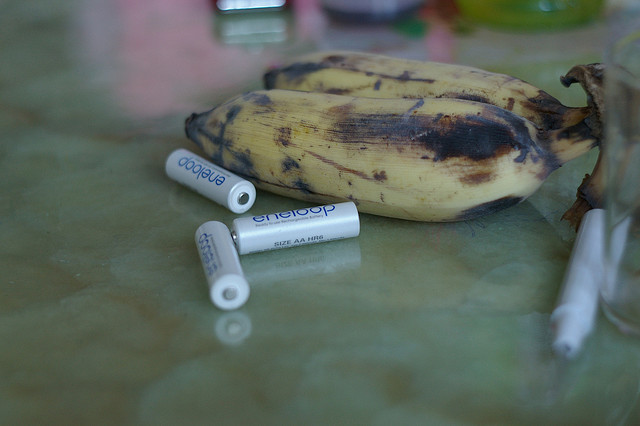

In [7]:
print(train_captions[0])
print(train_captions[1])
print(train_captions[2])
print(train_captions[3])
print(train_captions[4])
Image.open(img_name_vector[0])

### FEATURE EXTRACTION USING Inception V3

Inception v3 is an image recognition model that has been shown to attain greater than 78.1% accuracy on the ImageNet dataset. The model is made up of symmetric and asymmetric building blocks, including convolutions, average pooling, max pooling, concatenations, dropouts, and fully connected layers. Batch normalization is used extensively throughout the model and applied to activation inputs. Loss is computed using Softmax.
In this project, we have used a model with pretrained weights. The images are resized and the preprocessing function is used to preprocess the image set. The output of this model is used to store the results in a dictionary which contains the feature vector set in the image. The final output is saved. 

In [8]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.keras.layers.Resizing(299, 299)(img)
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

In [9]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

87924736/87910968 [==============================] - 0s 0us/step


In [10]:

encode_train = sorted(set(img_name_vector))

image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(16)

for img, path in image_dataset:
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())

In [11]:
caption_dataset = tf.data.Dataset.from_tensor_slices(train_captions)
def standardize(inputs):
  inputs = tf.strings.lower(inputs)
  return tf.strings.regex_replace(inputs,
                                  r"!\"#$%&\(\)\*\+.,-/:;=?@\[\\\]^_`{|}~", "")

max_length = 50
vocabulary_size = 5000
tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=vocabulary_size,
    standardize=standardize,
    output_sequence_length=max_length)

tokenizer.adapt(caption_dataset)

In [12]:

cap_vector = caption_dataset.map(lambda x: tokenizer(x))

In [13]:

word_to_index = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary())
index_to_word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
    invert=True)

### DIVIDE THE DATA INTO TESTING AND TRAINING DATASETS

In [14]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(img_name_vector, cap_vector):
  img_to_cap_vector[img].append(cap)

img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
  capt_len = len(img_to_cap_vector[imgt])
  img_name_train.extend([imgt] * capt_len)
  cap_train.extend(img_to_cap_vector[imgt])

img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
  capv_len = len(img_to_cap_vector[imgv])
  img_name_val.extend([imgv] * capv_len)
  cap_val.extend(img_to_cap_vector[imgv])

In [15]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(40017, 40017, 10006, 10006)

In [16]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
num_steps = len(img_name_train) // BATCH_SIZE
features_shape = 2048
attention_features_shape = 64

In [17]:

def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [18]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))


dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int64]),
          num_parallel_calls=tf.data.AUTOTUNE)


dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

## CREATING A MODEL

  The model is based on the Show-Attend and Tell paper. The features extracted from the last layer of the convolutional network are loaded into the encoder which consists of a fully connected layer. The output of this encoder is passed to the decoder and attention module. The decoder consists of a GRU layer and 2 dense layers which are used to generate captions. The attention module is used to generate an attention score to every pixel. This attention score helps the decoder to focus on the most important part of the image which in turn speeds up processing. Hence word-by-word, the caption is generated for an image. 

In [19]:
class model_Attention(tf.keras.Model):
  def __init__(self, units):
    super(model_Attention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    
    attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))

    
    score = self.V(attention_hidden_layer)

    
    attention_weights = tf.nn.softmax(score, axis=1)

    
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [20]:
class encoding(tf.keras.Model):
    
    
    def __init__(self, embedding_dim):
        super(encoding, self).__init__()
        
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [21]:
class decoding(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(decoding, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = model_Attention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    
    x = self.embedding(x)

    
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    
    output, state = self.gru(x)

    
    x = self.fc1(output)

    
    x = tf.reshape(x, (-1, x.shape[2]))

    
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [22]:
encoder = encoding(embedding_dim)
decoder = decoding(embedding_dim, units, tokenizer.vocabulary_size())

In [23]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')


def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [24]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

The model is trained over 20 epochs and the loss function is calculated to determine the fit of the model. 

In [25]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

In [26]:
loss_plot = []

In [27]:
@tf.function
def train_step(img_tensor, target):
  loss = 0

  
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([word_to_index('<start>')] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [28]:
EPOCHS = 20

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

Epoch 1 Batch 0 Loss 1.8732
Epoch 1 Batch 100 Loss 1.1166
Epoch 1 Batch 200 Loss 0.9581
Epoch 1 Batch 300 Loss 0.8275
Epoch 1 Batch 400 Loss 0.8709
Epoch 1 Batch 500 Loss 0.8427
Epoch 1 Batch 600 Loss 0.7319
Epoch 1 Loss 0.934780
Time taken for 1 epoch 203.11 sec

Epoch 2 Batch 0 Loss 0.7865
Epoch 2 Batch 100 Loss 0.7770
Epoch 2 Batch 200 Loss 0.7808
Epoch 2 Batch 300 Loss 0.6980
Epoch 2 Batch 400 Loss 0.6775
Epoch 2 Batch 500 Loss 0.6980
Epoch 2 Batch 600 Loss 0.6153
Epoch 2 Loss 0.732866
Time taken for 1 epoch 109.14 sec

Epoch 3 Batch 0 Loss 0.6547
Epoch 3 Batch 100 Loss 0.6690
Epoch 3 Batch 200 Loss 0.7830
Epoch 3 Batch 300 Loss 0.6708
Epoch 3 Batch 400 Loss 0.6430
Epoch 3 Batch 500 Loss 0.6637
Epoch 3 Batch 600 Loss 0.6334
Epoch 3 Loss 0.672154
Time taken for 1 epoch 108.73 sec

Epoch 4 Batch 0 Loss 0.6868
Epoch 4 Batch 100 Loss 0.6244
Epoch 4 Batch 200 Loss 0.6232
Epoch 4 Batch 300 Loss 0.5675
Epoch 4 Batch 400 Loss 0.6058
Epoch 4 Batch 500 Loss 0.6203
Epoch 4 Batch 600 Loss 0.61

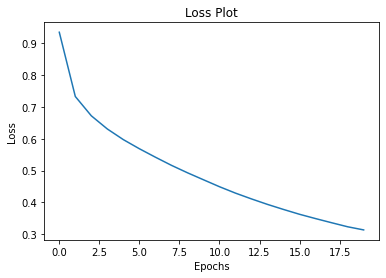

In [29]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

## TESTING THE MODEL

In [30]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                 -1,
                                                 img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([word_to_index('<start>')], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input,
                                                         features,
                                                         hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        predicted_word = tf.compat.as_text(index_to_word(predicted_id).numpy())
        result.append(predicted_word)

        if predicted_word == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [31]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for i in range(len_result):
        temp_att = np.resize(attention_plot[i], (8, 8))
        grid_size = max(int(np.ceil(len_result/2)), 2)
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(result[i])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

In [32]:
from ipykernel import kernelapp as app

Real Caption: </> a living room furnished with couches, [UNK] and [UNK] </>
Prediction Caption: a brown and black and black [UNK] up in a chair in a room </> and a living room with a brown couches and a chair in a room bed and beside it. </> on a black stand in a chair in a living room with a couch and a


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  from ipykernel import kernelapp as app


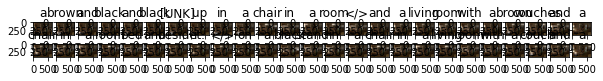

In [33]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tf.compat.as_text(index_to_word(i).numpy())
                         for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)

CONCLUSION

Captions are generated for the test images. There is no numerical criteria to evaluate how fitting these captions are to the given images. However, the captions generated generally recognize objects, object placements and context to a fair degree. 
Thus as future scope of this project, the captions generated can be evaluated to make sure that they are grammatically correct. 
The project also allows us to glimpse into the outputs of the decoder which give us more insight into how the captions are generated. We tracked the output of the decoder after every iteration to find out the word to index generated at the end of every cycle. 
